In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams

from utils import *
from methods import *
from models import *
from plotting_functions import *

In [3]:
# load trained model
model = torch.load('./optimal-models/JV7')
phases = model.phases.clone().detach().numpy()
wrapped_phases = model.unit_cell.wrap(phases)

[(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>),
 (<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)]

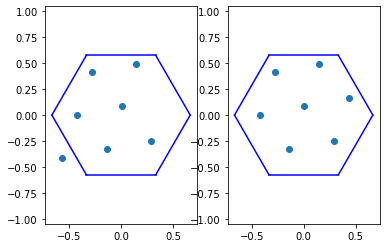

In [4]:
fig, axs = plt.subplots(ncols=2)
axs[0].scatter(*phases.T)
axs[1].scatter(*wrapped_phases.T)
[axs[i].axis('equal') for i in range(len(axs))]
[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]

### Test (Linear) decoding performance

In [5]:
def test_decoding(model,nsamples_space=1000):
    r = model.unit_cell.sample(nsamples_space)
    activity = model.forward(torch.tensor(r,dtype=torch.float32))
    model.train_decoder(torch.tensor(r,dtype=torch.float32))
    r_pred = model.decode(activity)
    r_pred = r_pred.detach().numpy()
    #r_wrapped = model.unit_cell.wrap(r_pred)
    return r, model.unit_cell.geodesic(r,r_pred)#np.sum((r-r_wrapped)**2,axis=-1)

0.23409295884654682


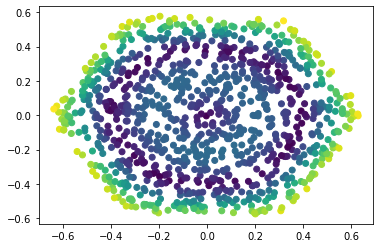

In [6]:
r, decoding_error = test_decoding(model)
print(np.mean(decoding_error))
plt.scatter(*r.T,c=decoding_error)

### Show The Jacobian

In [7]:
def test_detJ(model,nsamples_space=10000):
    r = model.unit_cell.sample(nsamples_space)
    J = model.jacobian(torch.tensor(r,dtype=torch.float32))
    det_J = model.the_jacobian(J)
    return r,det_J.detach().numpy()

In [8]:
r,detJ = test_detJ(model)

Text(0.5, 1.0, 'Var(det(J^T J)) = 3.7211067560605215e-12')

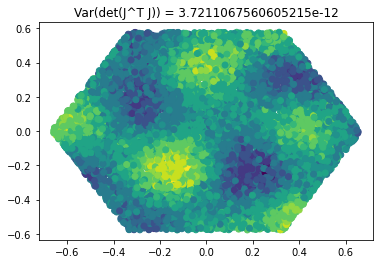

In [9]:
plt.scatter(*r.T,c=detJ)
plt.title(f"Var(det(J^T J)) = {np.var(detJ)}")

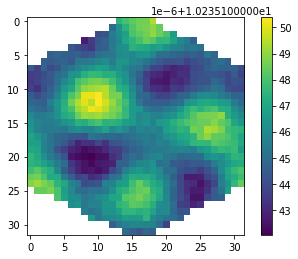

In [10]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,detJ,bins=32).statistic
plt.imshow(hist2d)
plt.colorbar()

### Show (low-dimensional projection) manifold

In [11]:
r = np.random.uniform(-1.2/2,1.2/2,size=(64**2,2))

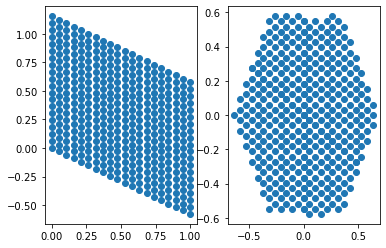

In [12]:
fig,axs = plt.subplots(ncols=2)
d = np.linalg.norm(model.unit_cell.basis[0])
r = np.random.uniform(0,1,size=(100**2,2))
r = np.mgrid[0:1:20j,0:1:20j].T.reshape(-1,2)
r = rhombus_transform(r)
axs[0].scatter(*r.T)
r = model.unit_cell.wrap(r)
axs[1].scatter(*r.T)

In [ ]:
1/(np.sqrt(3)/2)

1.1547005383792517

In [ ]:
np.sin(30*np.pi/180)

0.49999999999999994

In [ ]:
model.unit_cell.area

1.1547005383792515

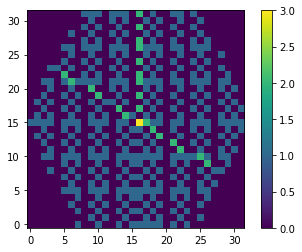

In [ ]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,np.zeros_like(r[:,0]),statistic='count',bins=32).statistic
plt.imshow(hist2d.T,origin='lower')
plt.colorbar()

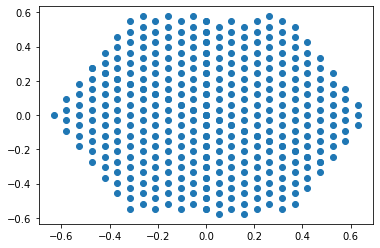

In [17]:
plt.scatter(*r.T)

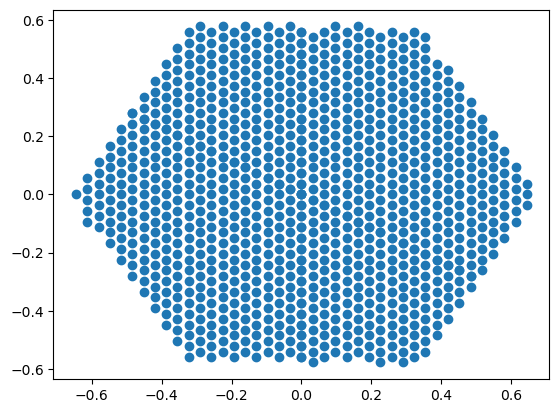

In [28]:
plt.scatter(*model.unit_cell.mesh(32).T)

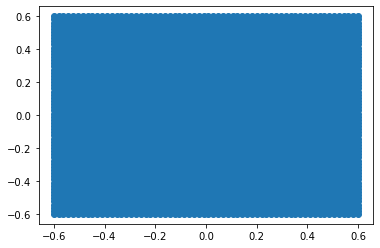

In [19]:
plt.scatter(*create_board(1.2).reshape(-1,2).T)

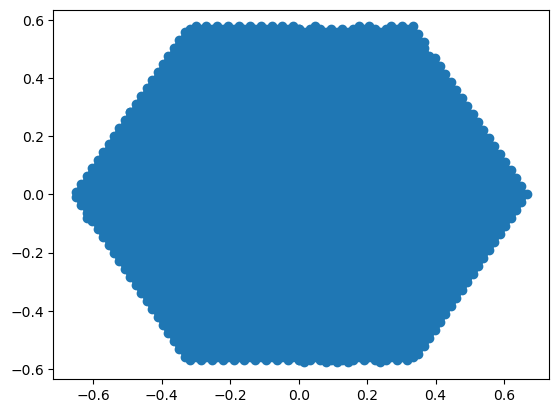

In [33]:
plt.scatter(*model.unit_cell.mesh(64).T)

In [58]:
def show_manifold(model,nsamples_space=10000):
    #r = np.random.uniform(-1.2/2,1.2/2,size=(64**2,2))
    #r = model.unit_cell.sample(nsamples_space)
    #r = create_board(1.2,to_torch_tensor=False).reshape(-1,2)
    #r = r[model.unit_cell.is_in_hexagon(r)]
    r = model.unit_cell.mesh(64)
    activity = model.forward(torch.tensor(r,dtype=torch.float32)).detach().numpy()
    projection = umap.UMAP(n_neighbors=15,n_components=3)
    return projection.fit_transform(activity), projection, activity

In [59]:
manifold, projection, activity = show_manifold(model)

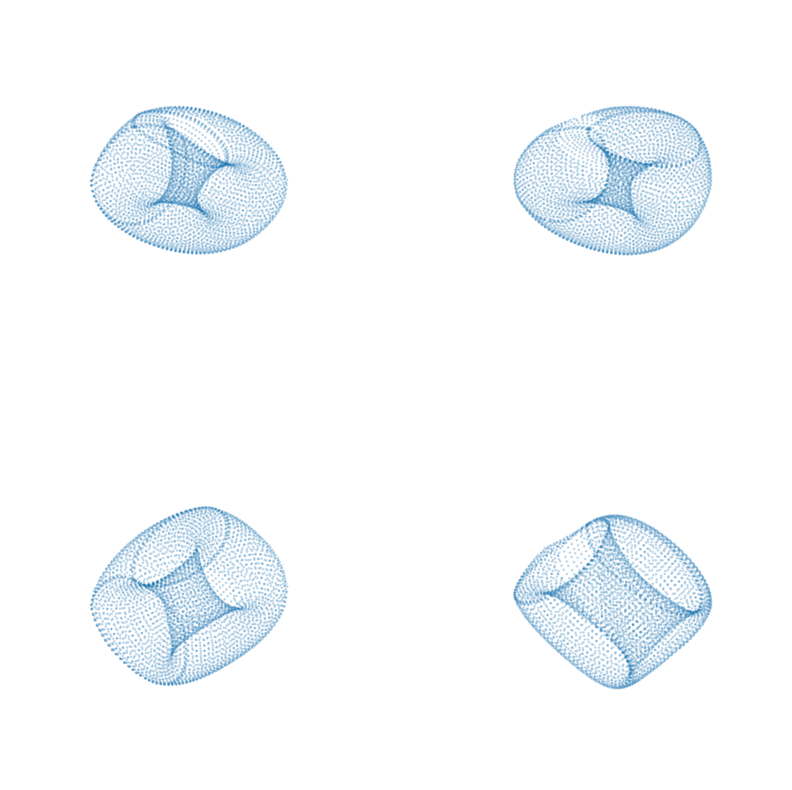

In [61]:
scatter3d(manifold,ncols=2,nrows=2,azim_elev_title=False,figsize=(10,10),alpha=0.2);

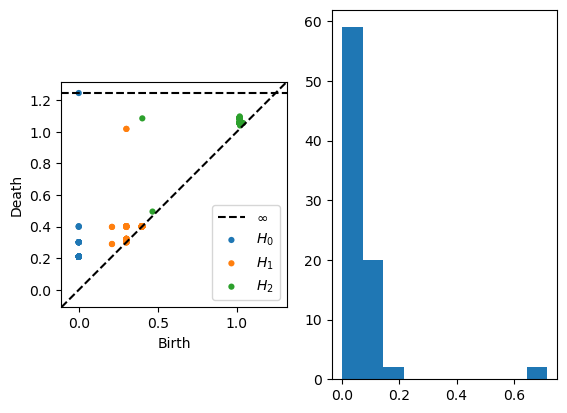

In [39]:

fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0]);